# File Description

This notebook downloads the COWCLIP (The Coordinated Ocean Wave Climate Project) projections from https://cowclip.org/data-access/.
    
It visualises and then saves the data locally

# File Set up

In [7]:
import netCDF4
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import itertools
import matplotlib.gridspec as gridspec
import dill
# import cartopy

In [163]:
import sys
!{sys.executable} -m pip install cartopy

  Using cached Cartopy-0.18.0.tar.gz (14.4 MB)


    ERROR: Command errored out with exit status 1:
     command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\shannonb\\AppData\\Local\\Temp\\pip-install-wwm95ily\\cartopy\\setup.py'"'"'; __file__='"'"'C:\\Users\\shannonb\\AppData\\Local\\Temp\\pip-install-wwm95ily\\cartopy\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\shannonb\AppData\Local\Temp\pip-install-wwm95ily\cartopy\pip-egg-info'
         cwd: C:\Users\shannonb\AppData\Local\Temp\pip-install-wwm95ily\cartopy\
    Complete output (3 lines):
    C:\Users\shannonb\AppData\Local\Temp\pip-install-wwm95ily\cartopy\setup.py:107: UserWarning: Unable to determine GEOS version. Ensure you have 3.3.3 or later installed, or installation may fail.
      '.'.join(str(v) for v in GEOS_MIN_VERSION), ))
    Proj 4.9.0 must be 

# Load the Model Output

In [4]:
# Load the COWCLIP data from online (each combination of variables is stored in a different nc file)
var_list = ['Hs','Tm'] # Get the wave height and the wave period
rcp_list = ['45','85'] # get data fro RCP4.5 and RCP8.5
clim_model_list = [
    'ACCESS1-0',
    'BCC-CSM1-1',
    'CNRM-CM5',
    'GFDL-CM3',
    'HadGEM2-ES',
    'INM-CM4',
    'MIROC5',
    'MRI-CGCM3'
] # List of the all climate models that are in the COWCLIP database

# Create a dataframe that has each of the combinations of the climate models, rcp scenarios, and variables
iterations_list = list(itertools.product(var_list, rcp_list))
iterations_list = list(itertools.product(clim_model_list, iterations_list))
df_vars = pd.DataFrame(iterations_list)
df_vars['var'] = [x[0] for x in df_vars[1]]
df_vars['rcp'] = [x[1] for x in df_vars[1]]
df_vars.rename(columns={0:'clim_model'},inplace=True)
df_vars.drop(1,axis=1,inplace=True)


In [52]:
# Create an empty dictionary fo the 
wave_model_proj = {}

for index,row in df_vars.iterrows():
    weblink =\
    "http://thredds.aodn.org.au/thredds/dodsC/CSIRO/Climatology/COWCLIP2/global/CSIRO/{}/rcp{}/r1i1p1/glob/v201908/mon/{}/{}_glob_CSIRO_{}_rcp{}_r1i1p1_mon_208101-209912.nc".format(row['clim_model'],row['rcp'],row['var'],row['var'],row['clim_model'],row['rcp'])

    try:
        ds = netCDF4.Dataset(weblink)
    except:
        print(weblink)
        continue
    
    time = np.array(ds.variables['time'])
    lat = np.array(ds.variables['latitude'])
    long = np.array(ds.variables['longitude'])
    var = np.array(ds.variables['{}_avg'.format(row['var'])])
    
    wave_model_proj.update({
        tuple(row):{
            'time':time,
            'lat':lat,
            'long':long,
            'var':var
        }
    })
 

http://thredds.aodn.org.au/thredds/dodsC/CSIRO/Climatology/COWCLIP2/global/CSIRO/MRI-CGCM3/rcp45/r1i1p1/glob/v201908/mon/Hs/Hs_glob_CSIRO_MRI-CGCM3_rcp45_r1i1p1_mon_208101-209912.nc
http://thredds.aodn.org.au/thredds/dodsC/CSIRO/Climatology/COWCLIP2/global/CSIRO/MRI-CGCM3/rcp85/r1i1p1/glob/v201908/mon/Hs/Hs_glob_CSIRO_MRI-CGCM3_rcp85_r1i1p1_mon_208101-209912.nc
http://thredds.aodn.org.au/thredds/dodsC/CSIRO/Climatology/COWCLIP2/global/CSIRO/MRI-CGCM3/rcp45/r1i1p1/glob/v201908/mon/Tm/Tm_glob_CSIRO_MRI-CGCM3_rcp45_r1i1p1_mon_208101-209912.nc
http://thredds.aodn.org.au/thredds/dodsC/CSIRO/Climatology/COWCLIP2/global/CSIRO/MRI-CGCM3/rcp85/r1i1p1/glob/v201908/mon/Tm/Tm_glob_CSIRO_MRI-CGCM3_rcp85_r1i1p1_mon_208101-209912.nc


# Plot the Model Output

## Significant Wave Height

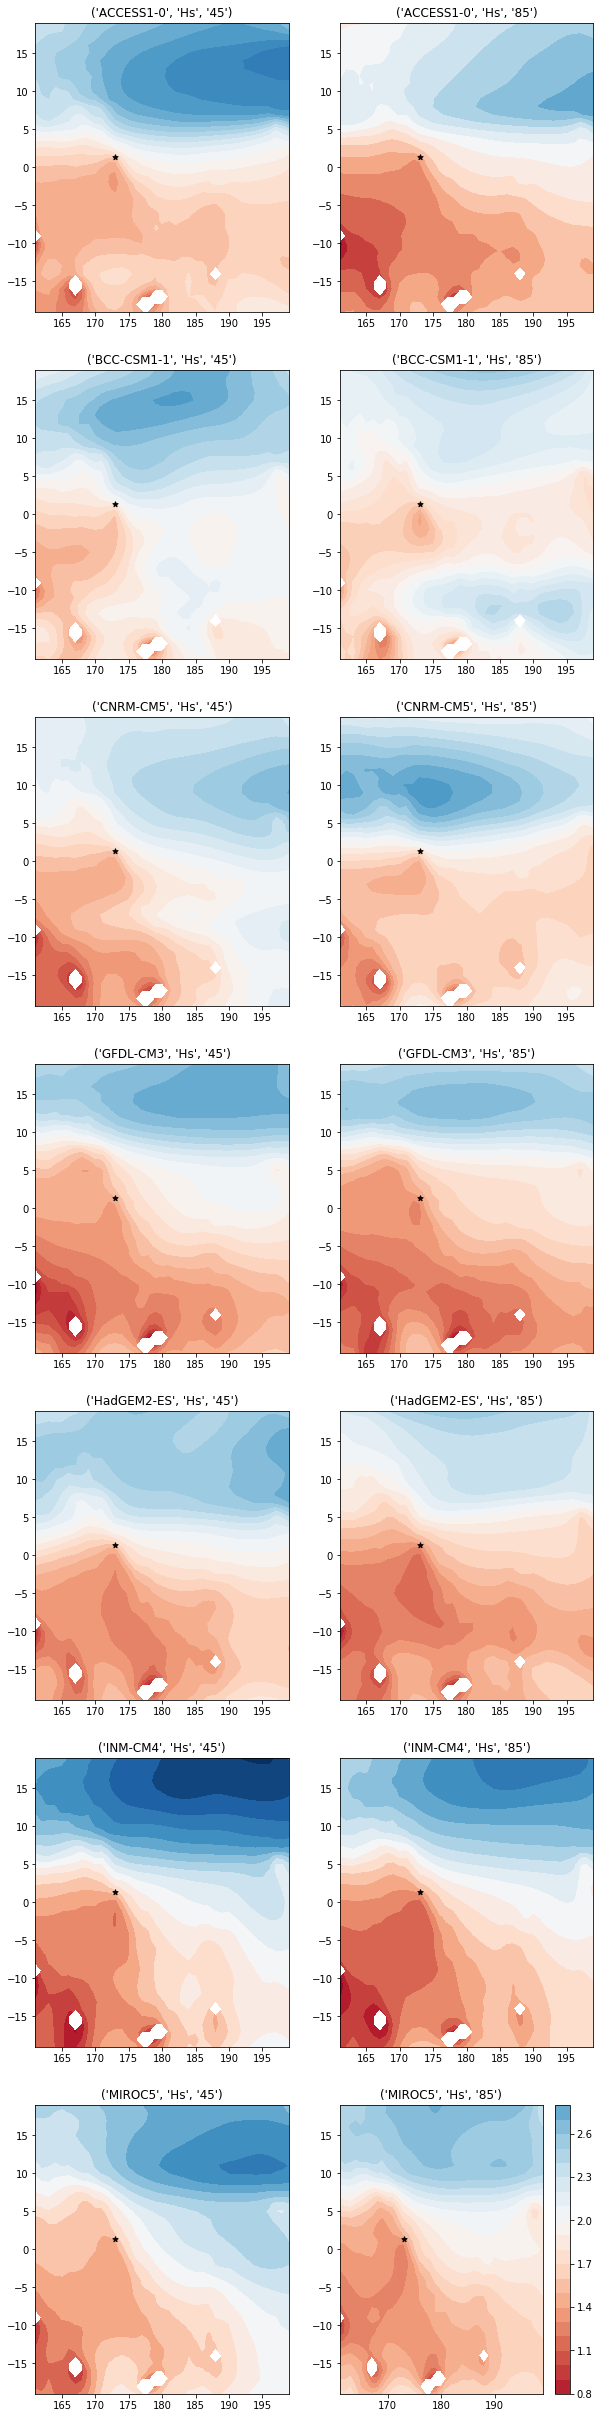

In [155]:
# Set the boundaries for the plot
lat_min = -20
lat_max = 20
long_min = 160
long_max = 200

# Set up the figure
fig = plt.figure(figsize=(10,50))
gs = fig.add_gridspec(ncols=2,nrows=int(len(iterations_list)/4))

i = 0

# Create an empty dictionary to put the tarawa Hs value into
tarawa_Hs_projections = {}

# Loop over each of the climate model outputs, and plot to an axis
for key,model_output in wave_model_proj.items():

    # In this plot, we only want to look at the significant wave height
    if key[1]=='Hs':
        pass
    else:
        continue
    
    # Get the correct axis for this model output
    ax = plt.subplot(gs[i]) # (int(i/2)),(i%2)
    i+=1
    
    # Get the variables from the dictionary (no consideration given to time yet, just taking the first point)
    time = model_output['time'][0]
    var = model_output['var'][0,:,:]
    lat = model_output['lat']
    long = model_output['long']
    
    # Select just the Pacific region
    var = var[(lat>lat_min)&(lat<lat_max),:][:,(long>long_min)&(long<long_max)]
    lat = lat[(lat>lat_min)&(lat<lat_max)]
    long = long[(long>long_min)&(long<long_max)]
    
    # Plot the model output
    output = ax.contourf(long,lat,var,levels=20,vmin=0.5,vmax=3.5,cmap='RdBu')
    ax.scatter([173],[1.3],marker='*',s=30,c='k')
    ax.set_title(key)
    
    # Get the values for at Tarawa to add to a bar chart (next cell)
    closest_lat = min(lat, key=lambda x:abs(x-1.3))
    closest_long = min(long, key=lambda x:abs(x-173))
    closest_value = var[np.where(lat==closest_lat)[0][0],np.where(long==closest_long)[0][0]]
    
    tarawa_Hs_projections.update({
        key:closest_value
    })

plt.colorbar(output)    
    
plt.show()    

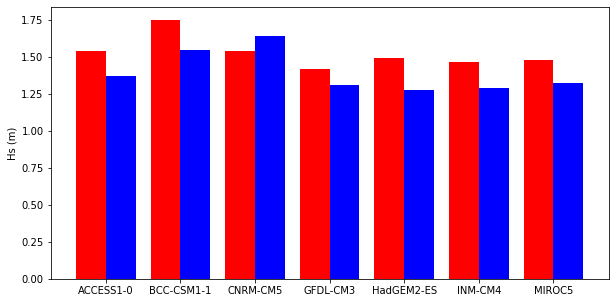

In [147]:
# Set up the figure
fig = plt.figure(figsize=(10,5))
ax = fig.gca()

# Create a dataframe form the dictionary of the significant wave heights
df_tarawa_Hs = pd.DataFrame.from_dict(tarawa_Hs_projections,orient='index',columns=['Hs'])
df_tarawa_Hs['model'] = [x[0] for x in df_tarawa_Hs.index]
df_tarawa_Hs['rcp'] = [x[2] for x in df_tarawa_Hs.index]
df_tarawa_Hs.reset_index(drop=True,inplace=True)

# Split the dataframe into the two RCP scenarios
df_tarawa_Hs_45 = df_tarawa_Hs[df_tarawa_Hs['rcp']=='45']
df_tarawa_Hs_85 = df_tarawa_Hs[df_tarawa_Hs['rcp']=='85']

# Plot the results
ax.bar(x=np.arange(0,len(df_tarawa_Hs_45),1)-0.2,height=df_tarawa_Hs_45.Hs,color='r',width=0.4)
ax.bar(x=np.arange(0,len(df_tarawa_Hs_85),1)+0.2,height=df_tarawa_Hs_85.Hs,color='b',width=0.4)

ax.set_xticks(np.arange(0,len(df_tarawa_Hs_45),1))
ax.set_xticklabels(list(df_tarawa_Hs_85.model))
ax.set_ylabel('Hs (m)')

plt.show()

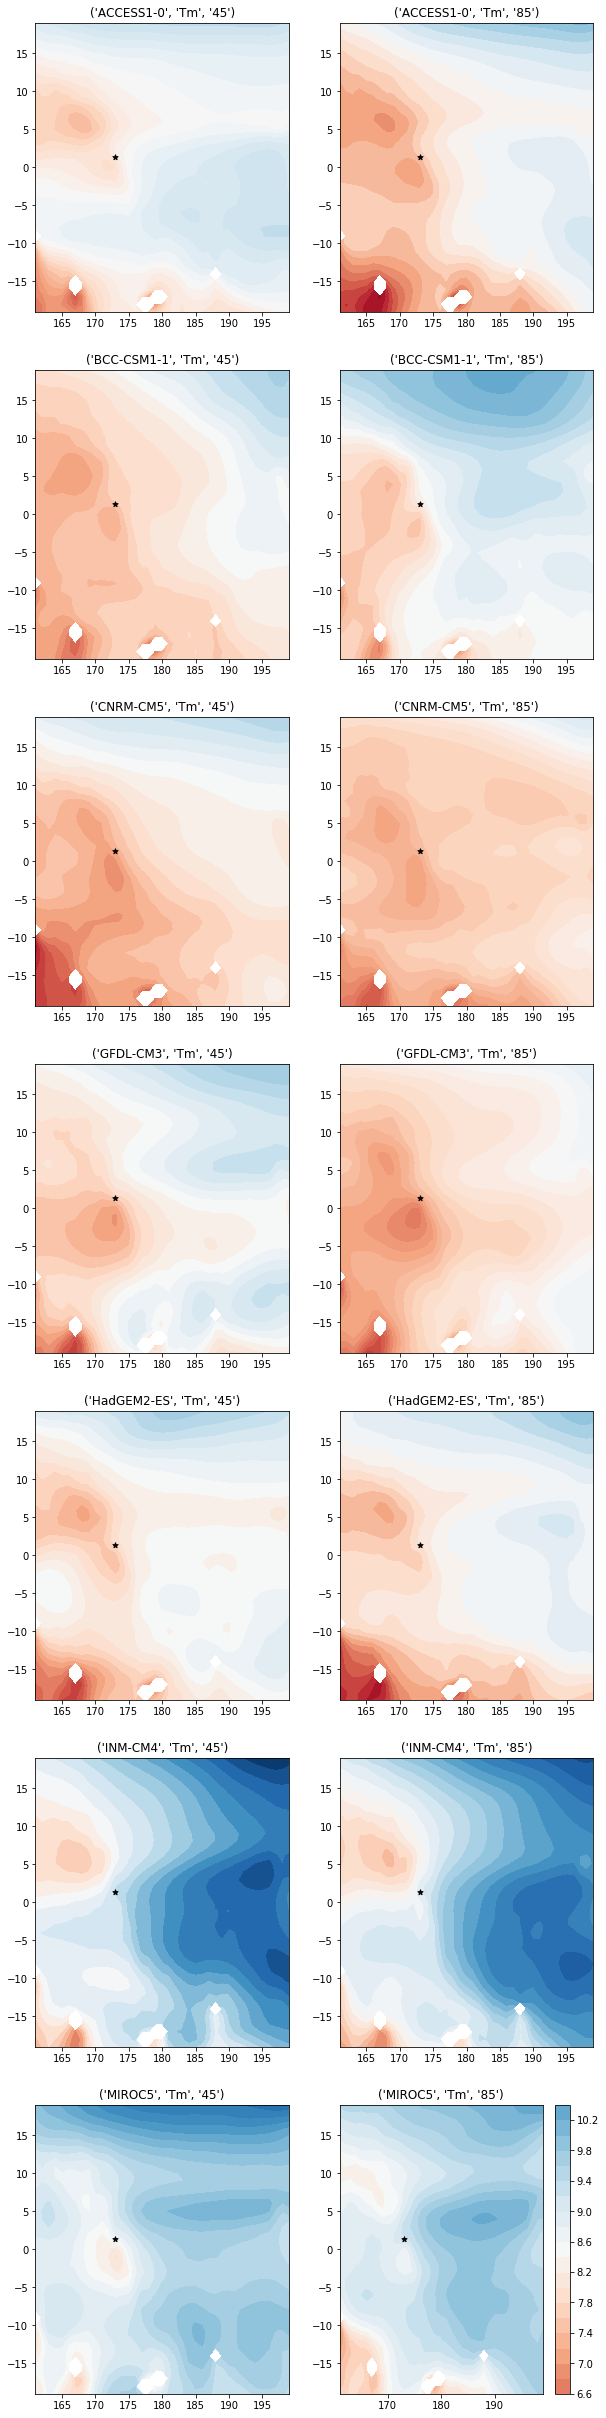

In [161]:
# Set the boundaries for the plot
lat_min = -20
lat_max = 20
long_min = 160
long_max = 200

# Set up the figure
fig = plt.figure(figsize=(10,50))
gs = fig.add_gridspec(ncols=2,nrows=int(len(iterations_list)/4))

# Create an empty dictionary to put the values from Tarawa into
tarawa_Tm_projections = {}

i = 0
# Loop over each of the climate model outputs, and plot to an axis
for key,model_output in wave_model_proj.items():

    # In this plot, we only want to look at the significant wave height
    if key[1]=='Tm':
        pass
    else:
        continue
    
    # Get the correct axis for this model output
    ax = plt.subplot(gs[i]) # (int(i/2)),(i%2)
    i+=1
    
    # Get the variables from the dictionary (no consideration given to time yet, just taking the first point)
    time = model_output['time'][0]
    var = model_output['var'][0,:,:]
    lat = model_output['lat']
    long = model_output['long']
    
    # Select just the Pacific region
    var = var[(lat>lat_min)&(lat<lat_max),:][:,(long>long_min)&(long<long_max)]
    lat = lat[(lat>lat_min)&(lat<lat_max)]
    long = long[(long>long_min)&(long<long_max)]
    
    # Plot the model output
    output = ax.contourf(long,lat,var,levels=20,vmin=5,vmax=12,cmap='RdBu')
    ax.scatter([173],[1.3],marker='*',s=30,c='k')
    ax.set_title(key)
    
    # Get the values for at Tarawa to add to a bar chart (next cell)
    closest_lat = min(lat, key=lambda x:abs(x-1.3))
    closest_long = min(long, key=lambda x:abs(x-173))
    closest_value = var[np.where(lat==closest_lat)[0][0],np.where(long==closest_long)[0][0]]
    
    tarawa_Tm_projections.update({
        key:closest_value
    })
    
plt.colorbar(output)   

plt.show()    

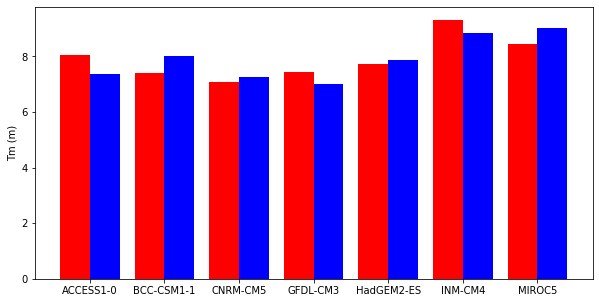

In [159]:
# Set up the figure
fig = plt.figure(figsize=(10,5))
ax = fig.gca()

# Create a dataframe form the dictionary of the significant wave heights
df_tarawa_Tm = pd.DataFrame.from_dict(tarawa_Tm_projections,orient='index',columns=['Hs'])
df_tarawa_Tm['model'] = [x[0] for x in df_tarawa_Tm.index]
df_tarawa_Tm['rcp'] = [x[2] for x in df_tarawa_Tm.index]
df_tarawa_Tm.reset_index(drop=True,inplace=True)

# Split the dataframe into the two RCP scenarios
df_tarawa_Tm_45 = df_tarawa_Tm[df_tarawa_Tm['rcp']=='45']
df_tarawa_Tm_85 = df_tarawa_Tm[df_tarawa_Tm['rcp']=='85']

# Plot the results
ax.bar(x=np.arange(0,len(df_tarawa_Tm_45),1)-0.2,height=df_tarawa_Tm_45.Hs,color='r',width=0.4)
ax.bar(x=np.arange(0,len(df_tarawa_Tm_85),1)+0.2,height=df_tarawa_Tm_85.Hs,color='b',width=0.4)

ax.set_xticks(np.arange(0,len(df_tarawa_Hs_45),1))
ax.set_xticklabels(list(df_tarawa_Hs_85.model))
ax.set_ylabel('Tm (m)')

plt.show()

# Save the data

In [68]:
with open(r'C:\Users\shannonb\Documents\Model_and_data\Dataset\D3_COWCLIP2\COWCLIP.pkl','wb') as file:
    dill.dump(wave_model_proj, file)
